## Prepare datasets

In [6]:
from dataset import (
    build_FIVES_dataloaders,
    build_hsi_dataloader,
    HSIDataset,
    build_FIVES_random_crops_dataloaders,
)
from torch.utils.data import DataLoader, Subset

trainloader_FIVES = (
    build_FIVES_random_crops_dataloaders(
        batch_size=16,
        num_channels=1,
        load_from_path='data/FIVES_random_crops_threshold01'
    )
)[0]

window = (700, 900)
target_augmented= True
trainloader_HSI = build_hsi_dataloader(
    batch_size=1,
    train_split=1,
    val_split=0,
    test_split=0,
    window=window,
    exclude_labeled_data=True,
    augmented=target_augmented,
)[0]

path = "./data/helicoid_with_labels"
testset_HSI = HSIDataset(path, with_gt=True, window=window)
testset_HSI.crop_dataset()
testloader_HSI = DataLoader(testset_HSI, batch_size=8, shuffle=False)

print(len(trainloader_HSI.dataset), len(testset_HSI))

Number of samples in the training set: 534, validation set: 60
Number of samples in the test set: 200
62 5


## Plot Intensity

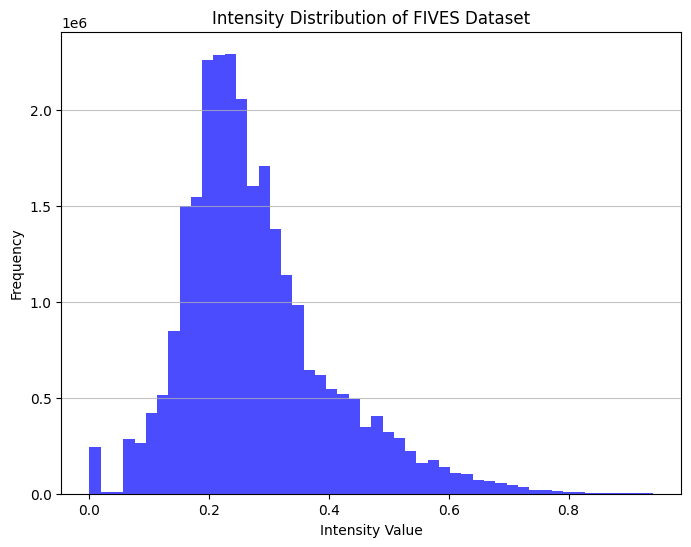

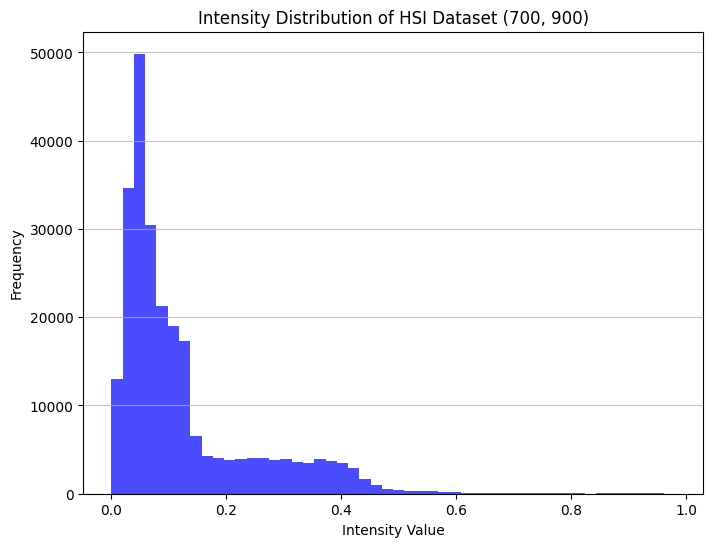

In [ ]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader


def plot_intensity(dataloader, bins=50, title="Intensity Distribution of Dataset"):
    """
    Plots the intensity distribution of a PyTorch dataset.

    Args:
        dataset (Dataset): PyTorch dataset containing the data.
        batch_size (int): Batch size for DataLoader.
        bins (int): Number of bins for the histogram.
    """

    # Collect intensity values from the dataset
    intensities = []
    for batch in dataloader:
        image = batch[0]
        intensities.append(image.flatten())

    # Flatten all intensities into a single array
    intensities = torch.cat(intensities).numpy()

    # Plotting the intensity distribution
    plt.figure(figsize=(8, 6))
    plt.hist(intensities, bins=bins, alpha=0.7, color="blue")
    plt.title(title)
    plt.xlabel("Intensity Value")
    plt.ylabel("Frequency")
    plt.grid(axis="y", alpha=0.75)
    plt.show()


plot_intensity(trainloader_FIVES, title="Intensity Distribution of FIVES Dataset")
# plot_intensity(trainloader_HSI, title=f'Intensity Distribution of HSI Dataset {window}')
plot_intensity(testloader_HSI, title=f"Intensity Distribution of HSI Dataset {window}")

## SNR

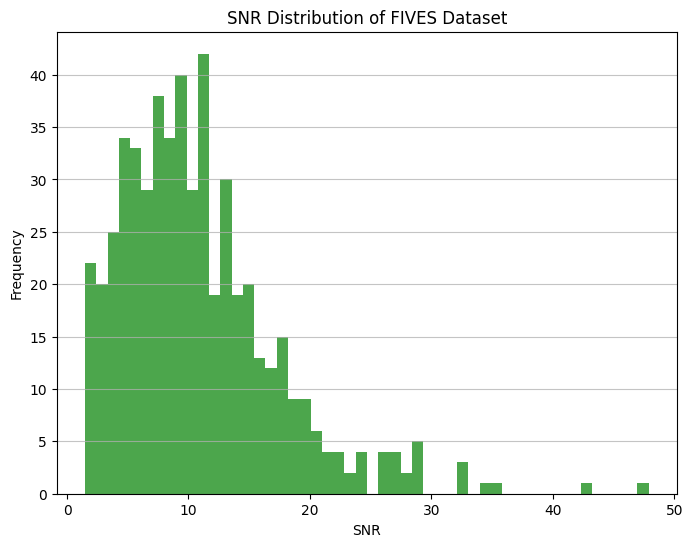

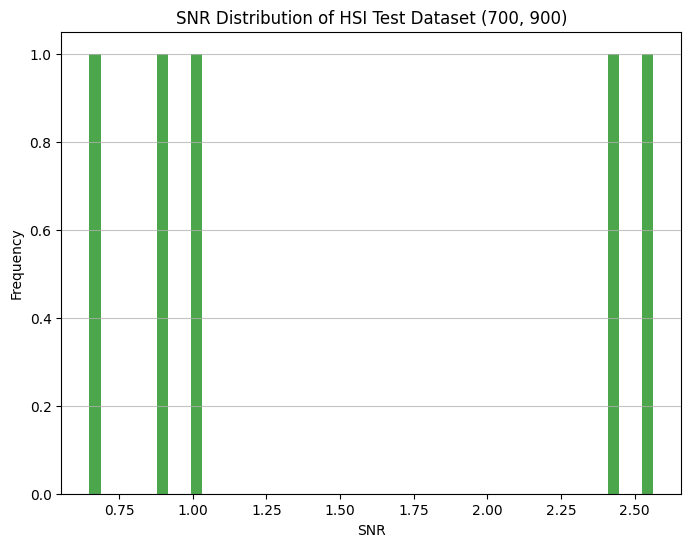

/tmp/ipykernel_1105734/1235949428.py:28: RuntimeWarning: Mean of empty slice.
  mu_signal = signal_region.mean()
/home/home/tim_ivan/idp/.venv/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


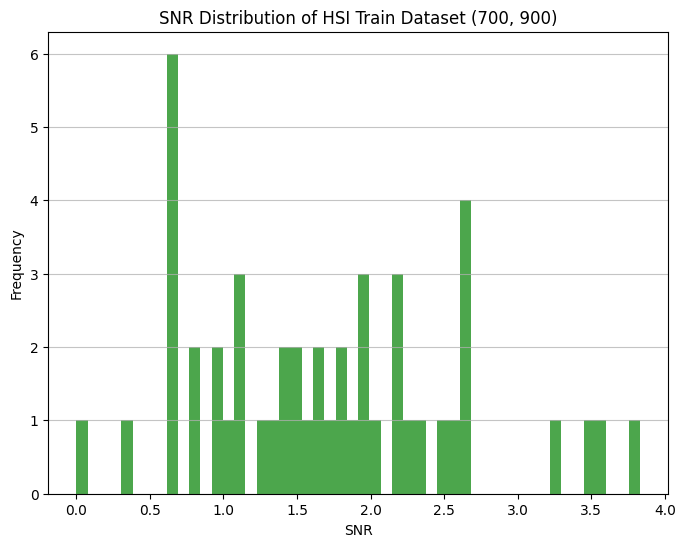

In [11]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader


def compute_snr(image, label):
    """
    Compute the Signal-to-Noise Ratio (SNR) for a given image and segmentation label.

    Args:
        image (torch.Tensor): The image tensor of shape (1, H, W).
        label (torch.Tensor): The segmentation label tensor of shape (1, H, W).

    Returns:
        float: The SNR value.
    """
    # Ensure image and label are in numpy format for easier indexing
    image = image.squeeze().numpy()
    label = label.squeeze().numpy()

    # Signal: Pixels where the label > 0
    signal_region = image[label > 0]

    # Background: Pixels where the label == 0
    background_region = image[label == 0]

    # Compute signal statistics
    mu_signal = signal_region.mean()

    # Compute noise as the standard deviation of the background
    sigma_noise = background_region.std()

    # Compute SNR
    if sigma_noise == 0:
        return float("inf")  # Handle edge case where noise is zero
    snr = mu_signal / sigma_noise
    return snr


def plot_snr_distribution(dataloader, bins=50, title="SNR Distribution of Dataset"):
    """
    Compute and plot the SNR distribution for a dataset.

    Args:
        dataset (Dataset): PyTorch dataset containing images and labels.
        batch_size (int): Batch size for DataLoader.
        bins (int): Number of bins for the histogram.
    """

    # Collect SNR values
    snr_values = []
    for batch in dataloader:
        images, labels = batch[0], batch[1]
        for i in range(images.size(0)):
            snr = compute_snr(images[i], labels[i])
            snr_values.append(snr)

    # Plotting the SNR distribution
    plt.figure(figsize=(8, 6))
    plt.hist(snr_values, bins=bins, alpha=0.7, color="green")
    plt.title(title)
    plt.xlabel("SNR")
    plt.ylabel("Frequency")
    plt.grid(axis="y", alpha=0.75)
    plt.show()
    
plot_snr_distribution(trainloader_FIVES, title="SNR Distribution of FIVES Dataset")
plot_snr_distribution(testloader_HSI, title=f"SNR Distribution of HSI Test Dataset {window}")
plot_snr_distribution(trainloader_HSI, title=f"SNR Distribution of HSI Train Dataset {window}")